# MolGAN을 이용한 분자 생성

- MolGAN network을 tox21 dataset에 학습
 - 12,060개의 훈련 샘플과 647개의 테스트 샘플 제공
- MolGAN network은 Cao and Kipf가 처음 제안
 - "MolGAN: An implicit generative model for small molecular graphs" 
 - GAN을 그래프 데이터에 적용하고 강화학습을 통해서 특정 속성을 가진  분자를 생성하도록 함

- 구성 generator, dicriminator, reward network. 

- 생성기는 정규 분포를 갖는 sample (z)로부터 그래프를 생성하며 MLP를 사용. 구체적으로 dense adjacency tensor A (bond types)와 annotation matrix X (atom types)를 생성한다
- 판별기와 보상 네트워크는 같은 구조를 가지며 그래프를 입력으로 받는다. Relational-GCN과 MLP를 사용하여 출력을 얻는다
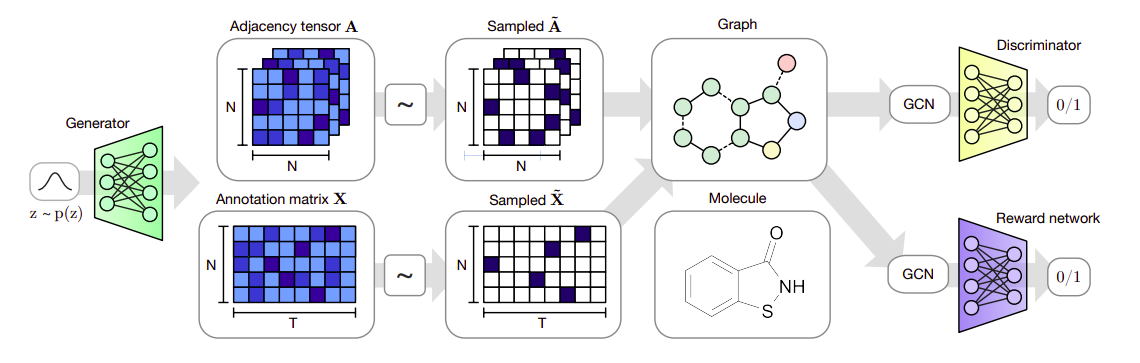

In [1]:
!pip install --pre deepchem
import deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 693 kB 37.3 MB/s 
     |████████████████████████████████| 29.5 MB 1.5 MB/s 


# Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from collections import OrderedDict

import deepchem as dc
import deepchem.models
from deepchem.models import BasicMolGANModel as MolGAN
from deepchem.models.optimizers import ExponentialDecay
import tensorflow as tf
from tensorflow import one_hot
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from deepchem.feat.molecule_featurizers.molgan_featurizer import GraphMatrix
import warnings
warnings.filterwarnings("ignore")

- tox21 데이터를 다운로드하고 SMILES을 추출한다

In [3]:
tasks, datasets, transformers = dc.molnet.load_tox21()
df = pd.DataFrame(data={'smiles': datasets[0].ids})

- 계산량을 줄이기 위해서 원자의 최대수를 12로 제한하겠다

In [4]:
num_atoms = 12

In [5]:
df

,smiles
0,CC(O)(P(=O)(O)O)P(=O)(O)O
1,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
2,OC[C@H](O)[C@@H](O)[C@H](O)CO
3,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]
4,CC(C)COC(=O)C(C)C
...,...
6259,CC1CCCCN1CCCOC(=O)c1ccc(OC2CCCCC2)cc1
6260,Cc1cc(CCCOc2c(C)cc(-c3noc(C(F)(F)F)n3)cc2C)on1
6261,O=C1OC(OC(=O)c2cccnc2Nc2cccc(C(F)(F)F)c2)c2ccc...
6262,CC(=O)C1(C)CC2=C(CCCC2(C)C)CC1C


In [6]:
# 샘플 수를 줄이는 방법
# data = df[['smiles']].sample(4000, random_state=42)
data = df

- 특성을 선택하면서, 최대 원자수, 원자번호 등을 제한할 수 있다

In [7]:
# create featurizer
feat = dc.feat.MolGanFeaturizer(max_atom_count=num_atoms, atom_labels=[0, 5, 6, 7, 8, 9, 11, 12, 13, 14]) #15, 16, 17, 19, 20, 24, 29, 35, 53, 80])

In [8]:
smiles = data['smiles'].values

Filter out the molecules with too many atoms to reduce the number of unnecessary error messages in later steps.

In [9]:
filtered_smiles = [x for x in smiles if Chem.MolFromSmiles(x).GetNumAtoms() < num_atoms]

In [10]:
filtered_smiles

['CC(O)(P(=O)(O)O)P(=O)(O)O',
 'OC[C@H](O)[C@@H](O)[C@H](O)CO',
 'CC(C)COC(=O)C(C)C',
 'C#CCO',
 'CC(O)CC(C)(C)O',
 'CC(C)(C)CC(C)(C)N',
 'CC(=O)CC(C)C',
 'CCCC(C)=O',
 'CC/C=C\\CCCCO',
 'CC(=O)CCC(C)=O',
 'N#CCCNCCC#N',
 'O=[N+]([O-])[O-].O=[N+]([O-])[O-].[Ca+2]',
 'F[B-](F)(F)F.[H+]',
 'CCCCCC(C)O',
 '[I-].[K+]',
 'C/C=C/C=C/C=O',
 'C[Si](C)(C)N[Si](C)(C)C',
 'C=CC(=O)OCCCl',
 'CCCCC(=O)[O-]',
 'CCCCCCC(C)O',
 'CCC[Si](OC)(OC)OC',
 'NCCNCCNCCN',
 'CCCCCNCCCCC',
 'COCC(C)O',
 'NCC(=O)CCC(=O)O',
 'ClCOCCl',
 'CC(O)CNCC(C)O',
 '[Cu]I',
 'CCCCCCCC(=O)OC',
 'CC(O)COCC(C)O',
 'CO[Si](C)(C)OC',
 'CCCCCCCCCC=O',
 'BrCBr',
 'CCC(Cl)CCl',
 'CCCCCCCCNC',
 'C=CC(=C)C',
 'CC(C)O',
 'CCCC(CCC)C(=O)[O-]',
 'CC(C)CNCC(C)C',
 'NC(=S)NNC(N)=S',
 'NC(=S)C(N)=S',
 'C[Hg]Cl',
 '[Hg+2]',
 'CC=CC(=O)CC',
 'O=[Cr](=O)([O-])O[Cr](=O)(=O)[O-]',
 'O=P(Cl)(Cl)Cl',
 'CC(N)CN',
 'CCC(C)O',
 'CC(O)CN',
 'O=C(O)[C@@H](S)[C@H](S)C(=O)O',
 'CC(C)(N)CO',
 'CC(C)(CO)CO',
 'O=[N+]([O-])C(CO)(CO)CO',
 'NC(CO)(CO)CO',
 'C

In [11]:
# featurize molecules
features = feat.featurize(filtered_smiles)

/usr/local/lib/python3.7/dist-packages/deepchem/feat/base_classes.py:323: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(features)


- GraphMatrix 타입 확인

In [12]:
indices = [ i for i, data in enumerate(features) if type(data) is GraphMatrix ]
# print(indices)
features = [features[i] for i in indices]

- MolGAN 모델을 만들고, learning rate와 최대 원자 갯수를 지정한다
- MolGAN의 입력에 맞도록 dataset를 준비한다

In [13]:
# 모델 생성
gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000), vertices=num_atoms)
dataset = dc.data.NumpyDataset([x.adjacency_matrix for x in features],[x.node_features for x in features])

- 배치단위로 읽는 함수를 정의

In [14]:
def iterbatches(epochs):
    for i in range(epochs):
        for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
            adjacency_tensor = one_hot(batch[0], gan.edges)
            node_tensor = one_hot(batch[1], gan.nodes)
            yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]:node_tensor}

- fit_gan 함수로 모델을 학습시키고, predict_gan_generator 함수로 분자를 생성한다

In [15]:
gan.fit_gan(iterbatches(25), generator_steps=0.2, checkpoint_interval=5000)
generated_data = gan.predict_gan_generator(1000)

Ending global_step 349: generator average loss -6.04866, discriminator average loss -11.7735
TIMING: model fitting took 14.164 s
Generating 1000 samples


- 생성된 그래프를 RDKit molecule 형태로 변환한다

In [16]:
nmols = feat.defeaturize(generated_data)
print("{} molecules generated".format(len(nmols)))

1000 molecules generated


- 변환이 제대로 되지 않는 분자 제거

In [17]:
nmols = list(filter(lambda x: x is not None, nmols))

- 유효한 분자수를 출력한다 

In [18]:
# currently training is unstable so 0 is a common outcome
print ("{} valid molecules".format(len(nmols)))

836 valid molecules


- 중복된 분자 제거

In [19]:
nmols_smiles = [Chem.MolToSmiles(m) for m in nmols]
nmols_smiles_unique = list(OrderedDict.fromkeys(nmols_smiles))
nmols_viz = [Chem.MolFromSmiles(x) for x in nmols_smiles_unique]
print ("{} unique valid molecules".format(len(nmols_viz)))

8 unique valid molecules


- 상위 100개의 분자 출력

In [20]:
img = Draw.MolsToGridImage(nmols_viz[0:100], molsPerRow=5, subImgSize=(250, 250), maxMols=100, legends=None, returnPNG=False)

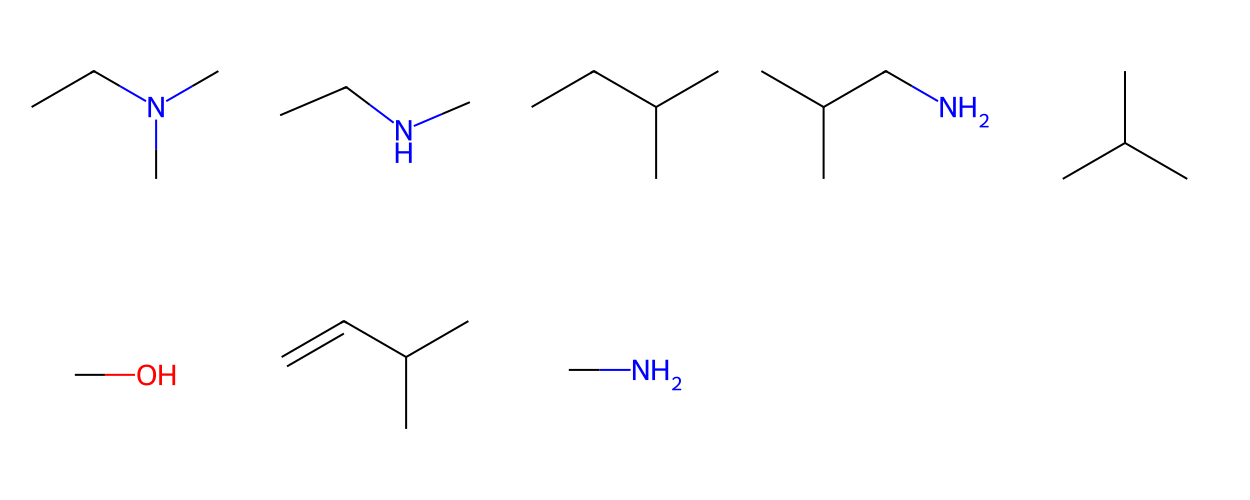

In [21]:
img

- 샘플 출력 예시

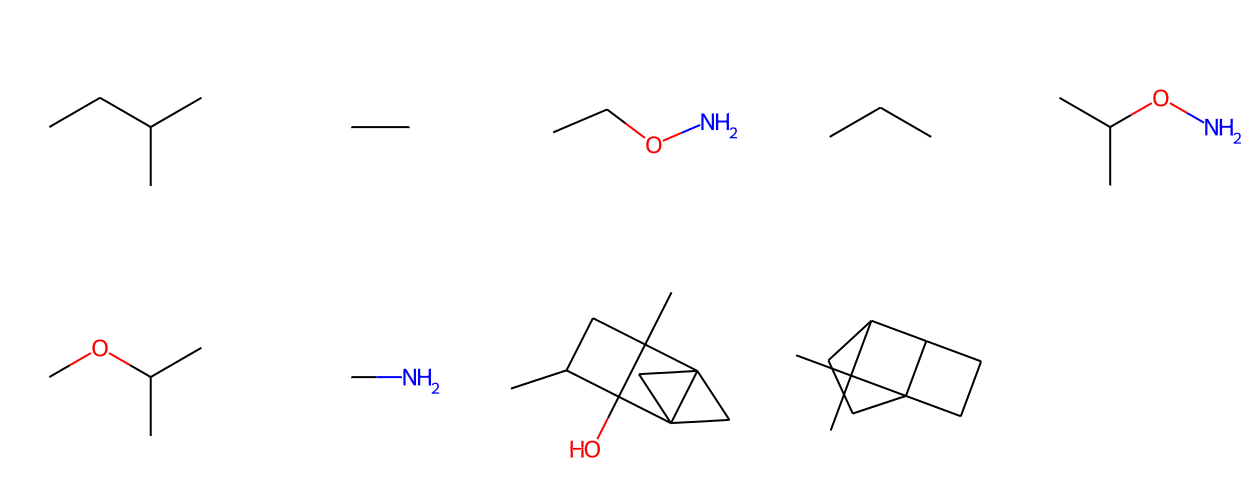